# 使用LSTM进行股票价格预测

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-07-21 15:59:12.973041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df=pd.read_csv('../dataset/TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09


## 数据集说明
- 数据集中包含了日期, 开盘价格(Open), 最高价(High), 最低价(Low), 最后一次交易价格
(Last), 收盘价格(Close), 总交易量(Total Trade Quantity), 周转金额(Turnover, 单位
10万)

- 接下来使用LSTM模型来预测收盘价, 首先可视化展示历史收盘股价

Text(0.5, 1.0, 'Close Price history')

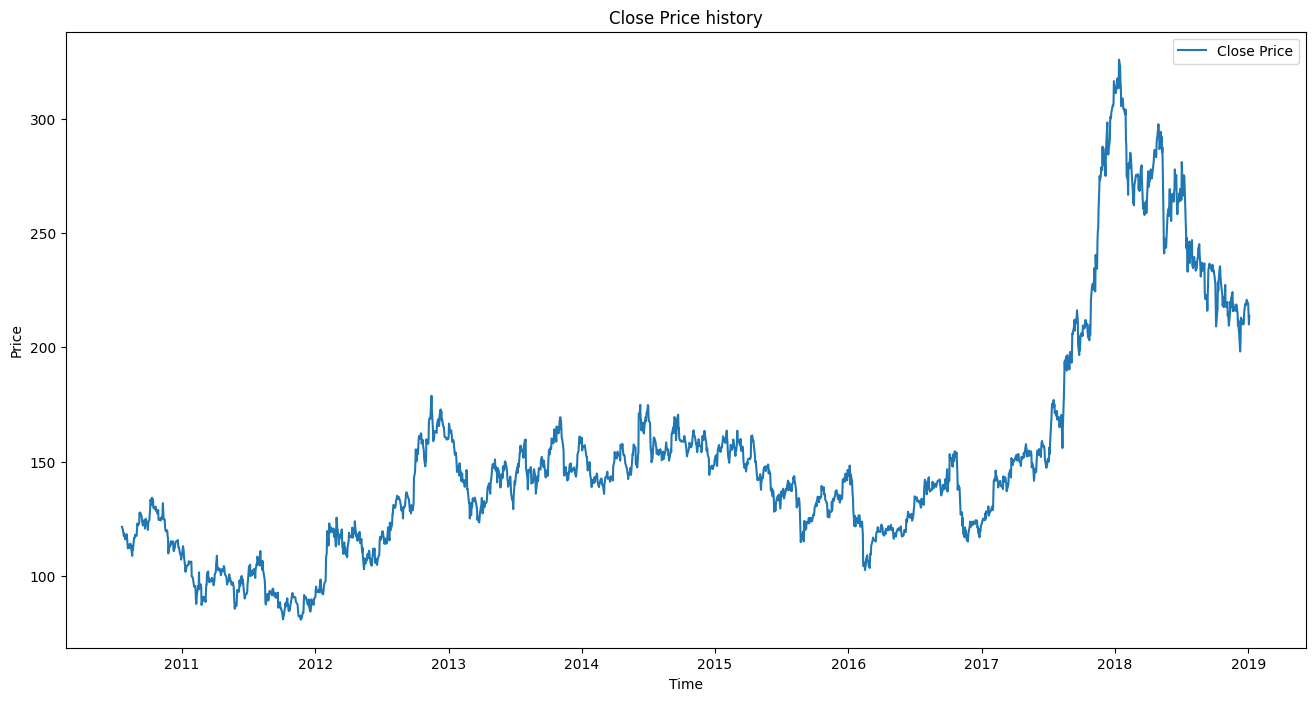

In [4]:
# Display stock close price history
df['Date']=pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(df['Close'],label='Close Price')
plt.legend(loc='best')
plt.title('Close Price history')

使用历史收盘股价预测未来股价, 预处理中删除其他列

In [5]:
# sort the dataset on date time, and filter 'Date' and 'Close' columns
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
print(len(df))

for i in range(0,len(data)):
    new_dataset['Date'][i]=data['Date'][i]
    new_dataset['Close'][i]=data['Close'][i]

2100


## 数据预处理

- **数据索引和清除**: 设置Date列为索引列, 因为他提供了股票价格的逻辑顺序. 由于该列不需要传入模型, 故将其删除;
- **数据规范化(Normalization)**: 将数据集中的数据规范化变换到范围[0,1]中. 这可以
  加速训练, 并且避免过大数值在训练过程中支配其他特征;
- **数据划分**: 数据集被划分为训练集和验证集. 前987个数据被用于训练, 其余用来验
  证. 该划分确保了模型在训练集上进行训练, 但在没有见到过的验证集序列上进行验证,
  帮助确保了模型可以在新数据上泛化良好;
- **特征和标签创建**: 对股票收市价格预测这个任务, 使用过去60天的数据来预测下一天
  的收市价格. 为了实现该目的, 创建连续60天的价格序列作为特征(X_train), 下一天的
  收市价格作为标签(y_train). 对整个训练集都如此处理;
- **数据变形**: 根据LSTM模型的需要, 将X_train从2D转为3D形式. 格式为[samples,
  time steps, features]. 其中`samples`是训练序列总数, `time steps`是每个序列的长
  度(60 days), `features`是序列中每天的特征(1特征, 即正规化的收市价).

In [6]:
train_size = 987
print(f"train_size[{train_size}]")

# set Date as index, and drop Date column
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)
print(new_dataset.head())

final_dataset = new_dataset.values

# normalize the new filtered dataset to range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# split train and valid data
train_data, valid_data = (
    final_dataset[:train_size,:],
    final_dataset[train_size:,:],
)

# Construct train arrays
X_train, y_train = [], []

for i in range(60, len(train_data)):
    X_train.append(scaled_data[i - 60 : i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

train_size[987]
             Close
Date              
2010-07-21  121.55
2010-07-22   120.9
2010-07-23  120.65
2010-07-26   117.6
2010-07-27  118.65
(927, 60)
(927, 60, 1)


## 模型架构和训练
- **模型架构**: 借助Keras库中的Sequential模型来搭建LSTM模型. 包含输入层具有50个单元的LSTM层,
`return_sequences`设置为`True`, 意味着下一层也是LSTM层. 第二个LSTM层有50个单元,
但是没有return sequences. 最终, 有一个具有一个unit的Dense layer, 输出预测的股票
收市价.
- **模型编译**: 在训练钱, 使用`adam`优化器和`mean_squared_error`损失函数来编译模
  型. 平均平方差是回归问题常见的损失函数, 计算预测值和实际值之间的平均平方差.
- **模型训练**: 使用`fit`函数对模型进行训练. 训练100轮(对数据集训练100次), 批次大小为1;
- **还原预测大小**: 由于模型训练在正规化数据上, 预测值也是被正规化的, 因此, 借助`inverse_transform`函数来还原预测收市价格到原本范围.

In [7]:
from keras.callbacks import EarlyStopping

# Build and train the LSTM model
lstm_model = Sequential()
lstm_model.add(
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))
)
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

inputs = new_dataset[len(new_dataset) - len(valid_data) - 60 :].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)
print(inputs.shape)

lstm_model.compile(loss="mean_squared_error", optimizer="adam")

# patience is the number of epochs to check for improvement
early_stop=EarlyStopping(monitor='val_loss', patience=10, verbose=1)

lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2, validation_split=0.2, callbacks=[early_stop])

2023-07-21 15:59:14.582620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 15:59:14.596146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 15:59:14.596323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 15:59:14.596755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

(1173, 1)
Epoch 1/100


2023-07-21 15:59:16.349128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-07-21 15:59:16.393478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-21 15:59:16.394141: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f027d723780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 15:59:16.394184: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-21 15:59:16.398826: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-21 15:59:16.475479: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the l

741/741 - 7s - loss: 0.0015 - val_loss: 7.1432e-04 - 7s/epoch - 10ms/step
Epoch 2/100
741/741 - 5s - loss: 7.6713e-04 - val_loss: 9.8199e-04 - 5s/epoch - 7ms/step
Epoch 3/100
741/741 - 3s - loss: 7.3787e-04 - val_loss: 8.0880e-04 - 3s/epoch - 5ms/step
Epoch 4/100
741/741 - 5s - loss: 5.5893e-04 - val_loss: 3.3829e-04 - 5s/epoch - 6ms/step
Epoch 5/100
741/741 - 4s - loss: 5.6176e-04 - val_loss: 8.9266e-04 - 4s/epoch - 6ms/step
Epoch 6/100
741/741 - 4s - loss: 4.9984e-04 - val_loss: 2.5765e-04 - 4s/epoch - 6ms/step
Epoch 7/100
741/741 - 5s - loss: 4.4709e-04 - val_loss: 4.4149e-04 - 5s/epoch - 6ms/step
Epoch 8/100
741/741 - 5s - loss: 3.9459e-04 - val_loss: 1.9746e-04 - 5s/epoch - 7ms/step
Epoch 9/100
741/741 - 5s - loss: 4.3092e-04 - val_loss: 2.6681e-04 - 5s/epoch - 7ms/step
Epoch 10/100
741/741 - 5s - loss: 4.0207e-04 - val_loss: 3.5336e-04 - 5s/epoch - 7ms/step
Epoch 11/100
741/741 - 5s - loss: 3.5193e-04 - val_loss: 0.0016 - 5s/epoch - 6ms/step
Epoch 12/100
741/741 - 5s - loss: 4.09

In [8]:
# take a sample of a dataset to make stock price predictions using the LSTM
# model
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)

print(X_test.shape)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_closing_price=lstm_model.predict(X_test)
# Restore origin data from normalized output
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

(1113, 60)
(1113, 60, 1)
35/35 [==============================] - 0s 2ms/step


In [9]:
# save the lstm model
lstm_model.save('model.h5')

## 可视化结果并评估模型性能
将预测股票价格和实际股票价格进行可视化, 可以看到预测价格较准确. 

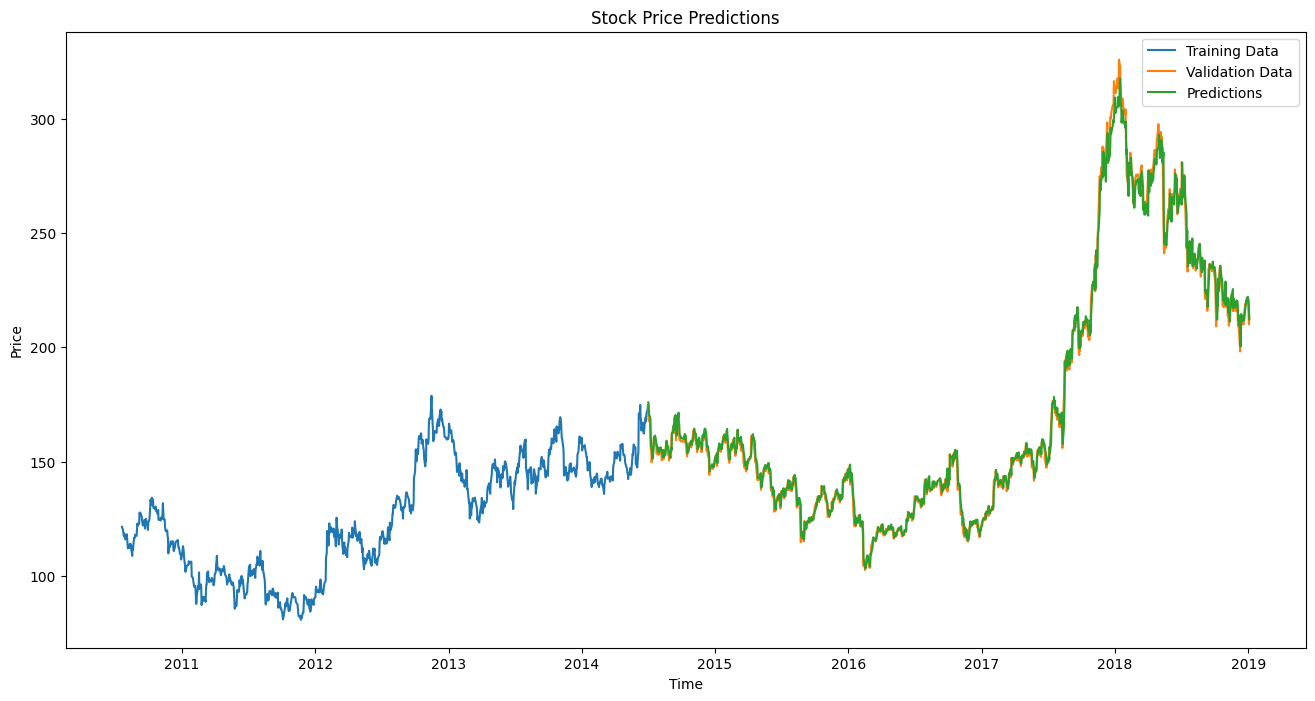

In [10]:
# visualize the predicted stock costs with actual stock costs
train_data = new_dataset[:train_size].copy()
valid_data = new_dataset[train_size:].copy()
valid_data.loc[:, "Predictions"] = predicted_closing_price

plt.figure(figsize=(16, 8))
plt.plot(train_data["Close"], label="Training Data")
plt.plot(valid_data["Close"], label="Validation Data")
plt.plot(valid_data["Predictions"], label="Predictions")
plt.title("Stock Price Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="best")
plt.show()

但是实际上使用LSTM将股价作为label进行预测的结果是没有价值的. 可以看到下面的代码
中, 使用昨天的股价作为第二天的预测价相比LSTM的拟合程度更好. 这是因为股价是非稳定
序列, 且相邻两天之间的变动很小. 

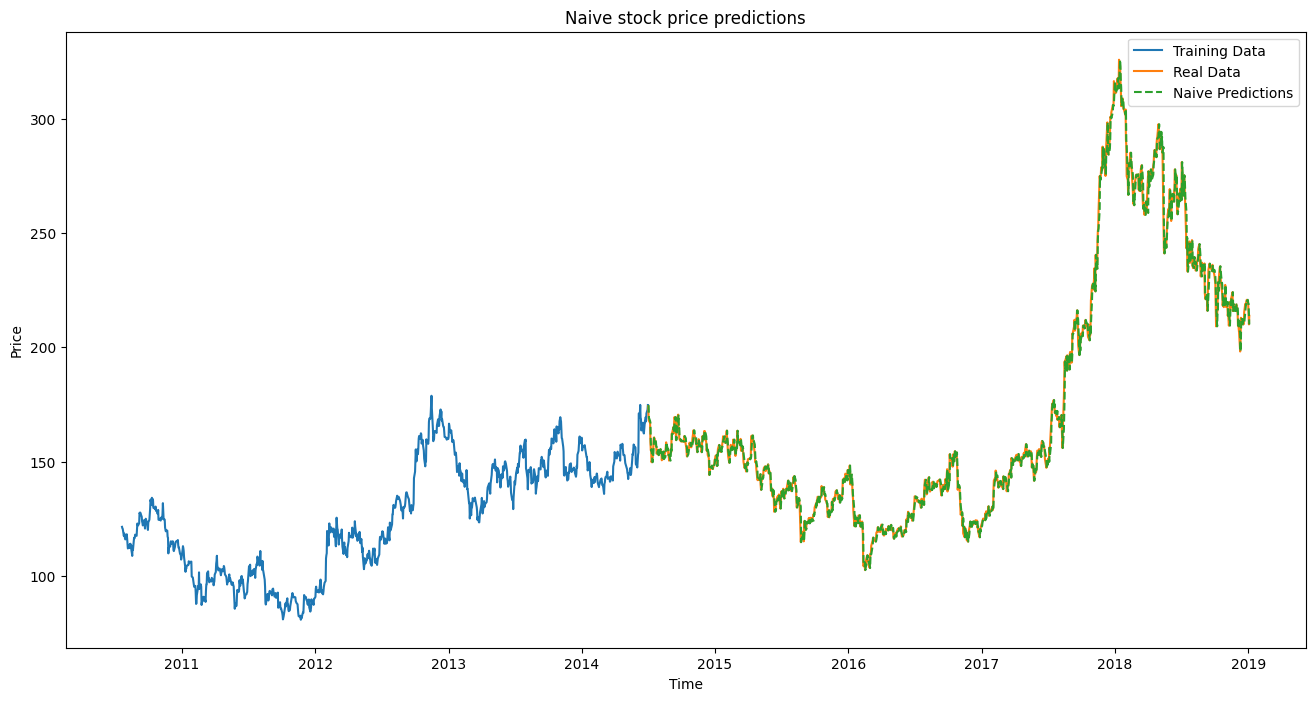

In [31]:
# Use yesterday's close price as today's predicted close price
train_data = new_dataset[:train_size].copy()
naive_data = new_dataset[train_size:].copy()
naive_data.loc[:, "Naive Predictions"] = new_dataset[train_size - 1 : -1][
    "Close"
].values

plt.figure(figsize=(16, 8))
plt.plot(train_data["Close"], label="Training Data")
plt.plot(naive_data["Close"], label="Real Data",linestyle='-')
plt.plot(
    naive_data.index,
    naive_data["Naive Predictions"],
    label="Naive Predictions",
    linestyle="--",
)
plt.title("Naive stock price predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="best")
plt.show()

# 使用预测差值图来评价两个模型的预测效果
预测股票的收益率, 或者涨跌是更好的方式. 将股票昨天和今天真实价格的差作为x轴, 预
测价格的差作为y轴画散点图进行观察.

可以看到, 两个模型的预测结果都是与x轴没有什么相关性的散点图. 因此本实验仅作为对
LSTM的了解和练习, 并不能帮助获取股票收益.

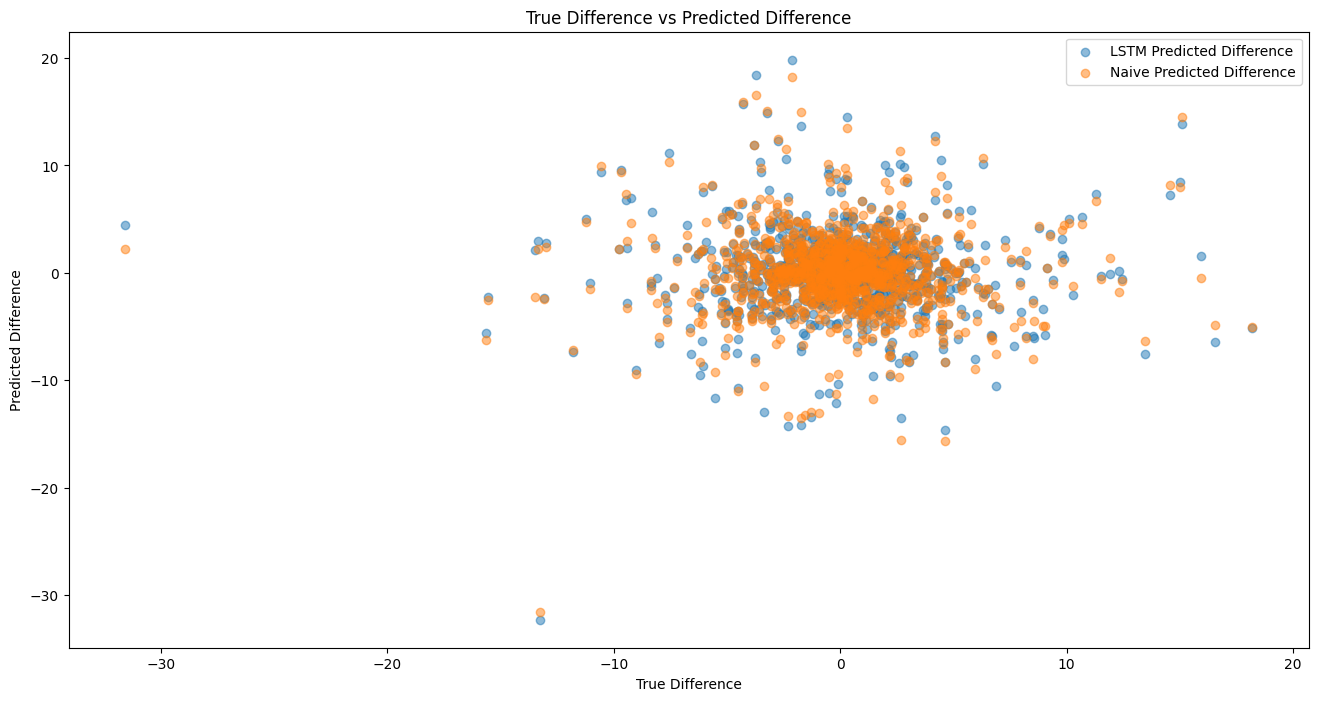

In [33]:
diff_data = pd.DataFrame(index=valid_data.index)

# calculate the true diff
diff_data['True_Difference']=valid_data['Close'].diff()

# calculate the prediction difference for LSTM and naive model
diff_data['LSTM_Predicted_Difference']=valid_data['Predictions'].diff()
diff_data['Naive_Predicted_Difference']=naive_data['Naive Predictions'].diff()

# create scatter figure
plt.figure(figsize=(16,8))
plt.scatter(diff_data['True_Difference'], diff_data['LSTM_Predicted_Difference'], label='LSTM Predicted Difference', alpha=0.5)
plt.scatter(diff_data['True_Difference'], diff_data['Naive_Predicted_Difference'], label='Naive Predicted Difference', alpha=0.5)
plt.title('True Difference vs Predicted Difference')
plt.xlabel('True Difference')
plt.ylabel('Predicted Difference')
plt.legend(loc='best')
plt.show()